In [1]:
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
def CI(M, p):
    value = M.values[p]
    lower = M.get_merrors()[p]['lower']
    upper = M.get_merrors()[p]['upper']
    return value + lower, value + upper

In [3]:
results = pd.DataFrame()

# Load C14 models

In [4]:
import c14_models

In [5]:
import importlib
importlib.reload(c14_models)

<module 'c14_models' from '/home/fabrost/work/C14_liver/c14_models.py'>

# Read patient data

In [6]:
c14_patient_data = pd.read_excel('data/C14data_liver_samples.xlsx')[['sort', 'Code', 'DOB', 'DOA', u'Δ 14C']]
c14_patient_data.columns = ['type', 'pub_id', 'Dbirth', 'Dcoll', 'd14C']
c14_patient_data['mass'] = 1.0
c14_patient_data['d14C'] /= 1000.0

In [7]:
hepatocyte_data = c14_patient_data.query('type == "unsorted"')
hepatocyte_data.describe()

,Dbirth,Dcoll,d14C,mass
count,9.000000,9.000000,9.000000,9.0
mean,1973.009259,2016.907407,0.046318,1.0
std,18.623203,0.419665,0.019564,0.0
min,1942.833333,2016.416667,0.022400,1.0
25%,1953.000000,2016.500000,0.029200,1.0
50%,1979.833333,2016.833333,0.043500,1.0
75%,1982.083333,2017.333333,0.059306,1.0
max,1995.333333,2017.416667,0.078416,1.0


# SSE & log-likelihood

In [8]:
def SSE(p, model, data):
    model_data = model(data['Dbirth'].values, 
                    data['Dcoll'].values, 
                    *p)
    sse = np.sum((model_data - data['d14C'].values)**2)
    return sse    

In [9]:
def Sigma(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sigma = np.sqrt(sse/n)
    return sigma

In [10]:
def Nloglike(p, model, data):
    try:
        sse = SSE(p, model, data)
    except:
        sse = SSE([p], model, data)
    n = len(data)
    sig = np.sqrt(sse/n)
    loglike = -n/2 * np.log(2*np.pi) - n/2 * np.log(sig**2) - 1 / (2*sig**2) * sse
    return -loglike

# Scenario I1

In [11]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    lam = np.exp(loglam)
    return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Artifical data

In [12]:
lam = 0.1
n = 20
np.random.seed(42)
artifical_data = pd.DataFrame(
                    data={'Dbirth': 
                               np.random.uniform(1930, 1970, n), 
                          'Dcoll': 
                               np.random.uniform(2014, 2018, n)}
                             )

artifical_data['d14C'] = I1(artifical_data['Dbirth'], 
                            artifical_data['Dcoll'], 
                            loglam=np.log(lam)) 
artifical_data['d14C'] += np.random.normal(0, 0.01, 
                                           len(artifical_data)
                                          )

In [13]:
artifical_data.head()

,Dbirth,Dcoll,d14C
0,1944.981605,2016.447412,0.068665
1,1968.028572,2014.557975,0.072392
2,1959.279758,2015.168579,0.084824
3,1953.946339,2015.465447,0.062206
4,1936.240746,2015.824280,0.074498


## Parameter recovery

In [14]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(10.0))],
                  args = (I1, artifical_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

In [15]:
lam = sp.exp(res[0])
print('lamda', lam)

sig = Sigma([np.log(lam)], I1, artifical_data)
print('sigma', sig)

lamda 0.1
sigma 0.00926419903019


# Plot

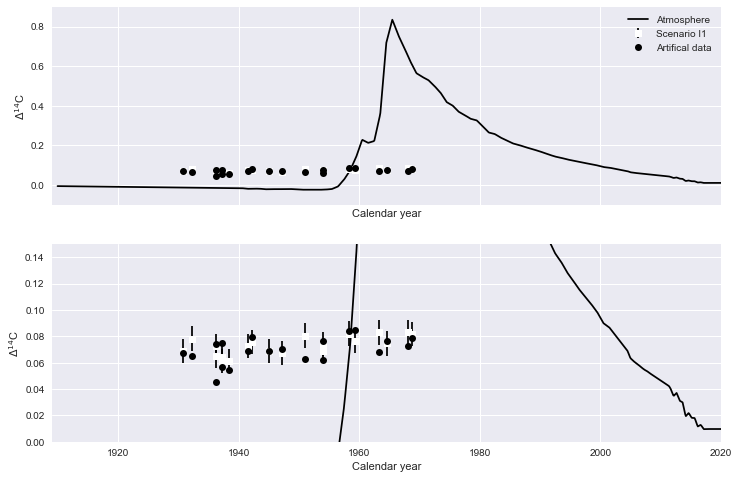

In [16]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (12, 8))

time = sp.linspace(1910.0, 2020.0, 1000)


for ax in axs:
    ax.plot(time, np.vectorize(c14_models.C_atm)(time), label = 'Atmosphere', color = 'black')

    ax.errorbar(artifical_data['Dbirth'], \
                I1(artifical_data['Dbirth'], 
                   artifical_data['Dcoll'], 
                   np.log(lam)), 
                sig,
                color = 'white', ecolor = 'black', 
                marker='s', ls = '',
                label = 'Scenario I1')


    ax.errorbar(artifical_data['Dbirth'], 
                artifical_data['d14C'], 
                marker = 'o', ls = 'None', color = 'black',
                label = 'Artifical data')
#     ax.errorbar(hepatocyte_data.query('Dcoll < 2015')['Dbirth'], hepatocyte_data.query('Dcoll < 2015')['d14C'], 
#                marker = 'o', ls = 'None', color = 'red', 
#                label = 'Hepato DNA (coll before 2015)')


    ax.set_xlim((1909, 2020))
    ax.set_ylim(-0.1, 0.9)
    ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
    # ax.grid(which='both')
    

    ax.set_xlabel('Calendar year')
    ax.set_ylabel('$\Delta^{14}$C')

axs[0].legend()
axs[1].set_ylim(-0.0, 0.15)

plt.show()